#CafChem Qiskit Quantum Chemistry examples

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/MauricioCafiero/CafChemQuantum/blob/main/Qiskit_Chemistry_CafChem.ipynb)

## This notebook allows you to:
- Load and import Qiskit libraries
- Create second quantized Hamiltonians for molecules
- Calculate integrals with PySCF
- Solve for energies
- Use a Variational Quantum Eigensolver to find energies for diatomics

## References
- *Quantum Chemistry and Computing for the Curious* by Keeper Layne Sharkey and Alex Khan

## Requirements:

- Runs well on CPU

## Install and import Qiskit and Qiskit Nature libraries and PySCF

In [1]:
#install qiskit 1.4.2
!pip install -q qiskit qiskit-nature qiskit_aer qiskit_algorithms
!pip install -q 'qiskit[visualization]'
!pip install -q pyscf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.8/327.8 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.6/51.6 MB 11.1 MB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit.visualization import array_to_latex, plot_bloch_vector, plot_bloch_multivector, plot_state_qsphere, plot_state_city
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
import qiskit.quantum_info as qi
from qiskit.circuit.library import Initialize
from qiskit.quantum_info import SparsePauliOp

from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper, BravyiKitaevMapper
from qiskit_nature.second_q.properties import ParticleNumber
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer, FreezeCoreTransformer
from qiskit_nature.second_q.operators import FermionicOp

from qiskit_nature import settings
from qiskit_nature.second_q.operators import ElectronicIntegrals

from qiskit.primitives import BaseSamplerV2
from qiskit_algorithms import HamiltonianPhaseEstimation, PhaseEstimation
from qiskit_aer.primitives import Estimator
from qiskit_algorithms.optimizers import SPSA, SLSQP, QNSPSA
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit.circuit.library import TwoLocal

from functools import partial as apply_variation

from pyscf import gto, scf

import cmath, math, time, datetime
import pandas as pd
import os.path

cd /usr/local/lib/python3.12/dist-packages/qiskit_nature/second_q/algorithms/excited_states_solvers/

vi qeom.py

BaseEstimator -> BaseEstimatorV2

## Use HF with PySCF to find the terms in the qubit Hamiltonian

### Define Functions

In [3]:
def get_particle_number(problem, print_flag: bool = False):
  '''
  '''
  num_particles = problem.num_particles
  num_spin_orbitals = problem.num_spin_orbitals

  if print_flag:
    print("Number of particles: ", num_particles)
    print("Number of spin orbitals: ", num_spin_orbitals)

  return num_particles, num_spin_orbitals

### H2 molecule

In [4]:
H2_atoms = ["H", "H"]
H2_coords = [(0.0, 0.0, 0.0),(0.0, 0.0, 0.735)]
H2_charge = 0
H2_multiplicity = 1
H2_atom_pair = (1,0)

H2_moleculeinfo = MoleculeInfo(H2_atoms, H2_coords, charge=H2_charge, multiplicity=H2_multiplicity)

In [5]:
H2_driver = PySCFDriver.from_molecule(
    H2_moleculeinfo,
    basis='6311g')

H2_problem = H2_driver.run()

H2_fermionic_hamiltonian = H2_problem.hamiltonian
H2_second_q_op = H2_fermionic_hamiltonian.second_q_op()

print('H2 molecule calculation  | basis = sto3g | HF method')
H2_num_particles, H2_num_spin_orbitals = get_particle_number(H2_problem, True)

H2 molecule calculation  | basis = sto3g | HF method
Number of particles:  (1, 1)
Number of spin orbitals:  12


In [6]:
H2_reference_energy = H2_problem.reference_energy
print(f'Reference energy: {H2_reference_energy:.3f} h')

Reference energy: -1.128 h


In [7]:
print('\n'.join(str(H2_second_q_op).splitlines()[:22]+ ["..."]))

Fermionic Operator
number spin orbitals=12, number terms=2628
  0.32653044800344927 * ( +_0 +_0 -_0 -_0 )
+ -0.06748377570216932 * ( +_0 +_0 -_2 -_0 )
+ -0.05028028605364943 * ( +_0 +_0 -_4 -_0 )
+ 0.17271304938833842 * ( +_0 +_1 -_1 -_0 )
+ 0.06719631509441784 * ( +_0 +_1 -_3 -_0 )
+ -0.012283102123301035 * ( +_0 +_1 -_5 -_0 )
+ -0.06748377570216932 * ( +_0 +_2 -_0 -_0 )
+ 0.18244348929818574 * ( +_0 +_2 -_2 -_0 )
+ 0.057192241061727093 * ( +_0 +_2 -_4 -_0 )
+ 0.06719631509441784 * ( +_0 +_3 -_1 -_0 )
+ 0.2529561675278308 * ( +_0 +_3 -_3 -_0 )
+ -0.0747725435632922 * ( +_0 +_3 -_5 -_0 )
+ -0.05028028605364943 * ( +_0 +_4 -_0 -_0 )
+ 0.057192241061727093 * ( +_0 +_4 -_2 -_0 )
+ 0.32134179283015013 * ( +_0 +_4 -_4 -_0 )
+ -0.012283102123301035 * ( +_0 +_5 -_1 -_0 )
+ -0.0747725435632922 * ( +_0 +_5 -_3 -_0 )
+ 0.3467079254219091 * ( +_0 +_5 -_5 -_0 )
+ 0.32653044800344927 * ( +_0 +_6 -_6 -_0 )
+ -0.06748377570216932 * ( +_0 +_6 -_8 -_0 )
...


### LiH Molecule

In [8]:
LiH_atoms = ["Li", "H"]
LiH_coords = [(0.0, 0.0, 0.0), (0.0, 0.0, 1.5474)]
LiH_charge = 0
LiH_multiplicity = 1
LiH_atom_pair = (1,0)

LiH_moleculeinfo = MoleculeInfo(LiH_atoms, LiH_coords, charge=LiH_charge, multiplicity=LiH_multiplicity)

In [9]:
LiH_driver = PySCFDriver.from_molecule(
    LiH_moleculeinfo,
    basis='6311g')
LiH_problem = LiH_driver.run()

transformer = FreezeCoreTransformer(freeze_core=True, remove_orbitals=[4, 3])
LiH_problem = transformer.transform(LiH_problem)

LiH_fermionic_hamiltonian = LiH_problem.hamiltonian
LiH_second_q_op = LiH_fermionic_hamiltonian.second_q_op()

print('LiH molecule calculation  | basis = sto3g | HF method')
print('Frozen core.')
LiH_num_particles, LiH_num_spin_orbitals = get_particle_number(LiH_problem, True)

LiH molecule calculation  | basis = sto3g | HF method
Frozen core.
Number of particles:  (1, 1)
Number of spin orbitals:  26


In [10]:
LiH_reference_energy = LiH_problem.reference_energy
print(f'Reference energy: {LiH_reference_energy:.3f} h')

Reference energy: -7.984 h


In [11]:
print('\n'.join(str(LiH_second_q_op).splitlines()[:22]+['...']))

Fermionic Operator
number spin orbitals=26, number terms=50718
  0.2412233689039941 * ( +_0 +_0 -_0 -_0 )
+ -0.020333940086979033 * ( +_0 +_0 -_1 -_0 )
+ -0.03304623222694187 * ( +_0 +_0 -_2 -_0 )
+ -0.002896789936753498 * ( +_0 +_0 -_3 -_0 )
+ 0.022739647652133363 * ( +_0 +_0 -_6 -_0 )
+ -0.03617930070436882 * ( +_0 +_0 -_7 -_0 )
+ -0.04188613250428339 * ( +_0 +_0 -_10 -_0 )
+ -0.021212292566201992 * ( +_0 +_0 -_11 -_0 )
+ 0.004064227111869865 * ( +_0 +_0 -_12 -_0 )
+ -0.020333940086979033 * ( +_0 +_1 -_0 -_0 )
+ 0.07646056378235883 * ( +_0 +_1 -_1 -_0 )
+ 0.014475071070470654 * ( +_0 +_1 -_2 -_0 )
+ -0.017337248128596803 * ( +_0 +_1 -_3 -_0 )
+ -0.015544119921352134 * ( +_0 +_1 -_6 -_0 )
+ 0.00967612239336305 * ( +_0 +_1 -_7 -_0 )
+ 0.006349392626515205 * ( +_0 +_1 -_10 -_0 )
+ 0.004324703573263759 * ( +_0 +_1 -_11 -_0 )
+ 0.00011095872507038073 * ( +_0 +_1 -_12 -_0 )
+ -0.03304623222694187 * ( +_0 +_2 -_0 -_0 )
+ 0.014475071070470654 * ( +_0 +_2 -_1 -_0 )
...


## Variational Quantum Eigensolver

### Functions

In [5]:
numpy_solver = NumPyMinimumEigensolver()
tl_circuit = TwoLocal(rotation_blocks=['h', 'rx'], entanglement_blocks='cz',
                      entanglement='full', reps=2, parameter_prefix='y')

estimator = Estimator()
optimizer = SPSA(maxiter=100)
vqe_tl_solver = VQE(estimator, tl_circuit, optimizer)

/tmp/ipython-input-316044768.py:2: DeprecationWarning: The class ``qiskit.circuit.library.n_local.two_local.TwoLocal`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.n_local instead.
  tl_circuit = TwoLocal(rotation_blocks=['h', 'rx'], entanglement_blocks='cz',


In [6]:
_EPS = 0.01

def bopes(info_dict, mapper_name, num_electrons, num_spatial_orbitals,
          two_qubit_reduction, z2symmetry_reduction, name_solver, perturbation_steps,
          mapper, solver, show=True):
  '''
  '''
  atoms = info_dict['atoms']
  coords = info_dict['coords']
  charge = info_dict['charge']
  multiplicity = info_dict['multiplicity']
  atom_pair = info_dict['atom_pair']

  size = len(perturbation_steps)

  energy = np.empty(size)

  x0 = coords[atom_pair[0]][0]
  y0 = coords[atom_pair[0]][1]
  z0 = coords[atom_pair[0]][2]
  x1 = coords[atom_pair[1]][0]
  y1 = coords[atom_pair[1]][1]
  z1 = coords[atom_pair[1]][2]

  if abs(x1-x0) >_EPS:
    m = (y1-y0)/(x1-x0)
    p = y0 - m*x0

  for k in range(size):
    if (abs(x0) < _EPS and abs(y0) < _EPS):
      zo_new = z0 + perturbation_steps[k]
      coords_new = []
      for l in range(len(coords)):
        if l == atom_pair[0]:
          coords_new.append((0.0, 0.0, zo_new))
        else:
          coords_new.append(coords[l])
    elif (abs(z0) < _EPS and abs(z1) < _EPS):
      xo_new = x0 + perturbation_steps[k]
      y0_new = m*xo_new + p
      coords_new = []
      for l in range(len(coords)):
        if l == atom_pair[0]:
          coords_new.append((xo_new, y0_new, 0.0))
        else:
          coords_new.append(coords[l])

    info_dict_new = {'atoms': atoms, 'coords': coords_new, 'charge': charge,
                     'multiplicity': multiplicity, 'atom_pair': atom_pair}

    fermionic_hamiltonian, num_partiles, num_spin_orbitals, qubit_op, mapper, ground_state = \
    solve_ground_state(info_dict_new, mapper_name, num_electrons, num_spatial_orbitals, None,
                       two_qubit_reduction, z2symmetry_reduction, name_solver, solver, qyqmc=False)

    energy[k] = ground_state.total_energies

  return perturbation_steps, energy



In [7]:
def get_particle_number(problem, print_flag: bool = False):
  '''
  '''
  num_particles = problem.num_particles
  num_spin_orbitals = problem.num_spin_orbitals

  if print_flag:
    print("Number of particles: ", num_particles)
    print("Number of spin orbitals: ", num_spin_orbitals)

  return num_particles, num_spin_orbitals

def fermion_to_qubit(problem, second_q_op, mapper_name, truncate=20, two_qubit_reduction=False, z2symmetry_reduction=None, show=True):
  '''
  '''
  if show:
    print('Qubit Hamiltonian')
    print(f'{mapper_name} transformation')

  match mapper_name:
    case 'JordanWignerMapper':
      mapper = JordanWignerMapper()
    case 'ParityMapper':
      mapper = ParityMapper(num_particles=problem.num_particles)
    case 'BravyiKitaevMapper':
      mapper = BravyiKitaevMapper

  qubit_op = mapper.map(second_q_op)

  if z2symmetry_reduction != None:
    tapered_mapper = problem.get_tapered_mapper(mapper)
    qubit_op = tapered_mapper.map(second_q_op)

  n_items = len(qubit_op)
  if show:
    print(f'Number of items in Pauli list: {n_items}')
    if n_items <= truncate:
      print(qubit_op)
    else:
      print(qubit_op[0:truncate])

  return qubit_op, mapper

def run_vqe(name, problem, qubit_convertor, solver, show=True):
  '''
  '''
  calc = GroundStateEigensolver(qubit_convertor, solver)
  start = time.time()
  ground_state = calc.solve(problem)
  elapsed = str(datetime.timedelta(seconds=time.time()-start))

  if show:
    print(f'Running VQE using the {name}')
    print(f'Elapsed time: {elapsed}')
    print(f'Total ground state energy: {ground_state}')

  return ground_state

def plot_energy_landscape(dist, energy):
  '''
  '''
  if len(dist) > 1:
    plt.plot(dist, energy, label = 'VQE Energy')
    plt.xlabel('Distance (angstrom)')
    plt.ylabel('Energy (h)')
    plt.legend()
    plt.show()
  else:
    print('No energy landscape to plot')
    print(f'Energy: {energy}')

def plot_loss(loss, label, target):
  '''
  '''
  plt.figure(figsize=(12, 6))
  plt.plot(loss, 'tab:green', ls='--', label=label)
  plt.axhline(target, color='tab:red', ls='--', label='Target')
  plt.xlabel('Number of function evaluations')
  plt.ylabel('Loss')
  plt.legend()
  plt.show

settings.use_pauli_sum_op = False

def solve_ground_state(info_dict, mapper_name='Parity', num_electrons=None, num_spatial_orbitals=None,
                       freeze_core=None, two_qubit_reduction=False, z2symmetry_reduction='Auto',
                       name_solver='NumPy exact solver', solver=NumPyMinimumEigensolver(), plot_bopes=False,
                       perturbation_steps=np.linspace(-1, 1, 3), qyqmc=False, n_ancillae=3, num_time_slices=1,
                       loss=[], label=None, target=None, show=True):
  '''
  '''
  atoms = info_dict['atoms']
  coords = info_dict['coords']
  charge = info_dict['charge']
  multiplicity = info_dict['multiplicity']
  atom_pair = info_dict['atom_pair']

  moleculeinfo = MoleculeInfo(atoms, coords, charge=charge, multiplicity=multiplicity)

  driver = PySCFDriver.from_molecule(moleculeinfo, basis='sto3g')

  if num_electrons != None and num_spatial_orbitals != None:
    split = ActiveSpaceTransformer(num_electrons=num_electrons, num_spatial_orbitals=num_spatial_orbitals)
  else:
    split=None

  problem = driver.run()
  if split != None:
    problem = split.transform(problem)
  elif freeze_core != None:
    problem = freeze_core.transform(problem)

  fermionic_hamiltonian = problem.hamiltonian
  second_q_op = fermionic_hamiltonian.second_q_op()

  if show:
    print('\n'.join(str(second_q_op).splitlines()[:22]+ ["..."]))

  num_particles, num_spin_orbitals = get_particle_number(problem, True)

  if show:
    print('')

  qubit_op, mapper = fermion_to_qubit(problem, second_q_op, mapper_name, two_qubit_reduction = two_qubit_reduction,
                                      z2symmetry_reduction = z2symmetry_reduction, show=show)

  if name_solver == 'VQE':
    ansatz = UCCSD(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
        initial_state=HartreeFock(problem.num_spatial_orbitals, problem.num_particles, mapper),
    )
    solver = VQE(Estimator(), ansatz, SLSQP())

  ground_state = run_vqe(name_solver, problem, mapper, solver, show=show)

  if loss != []:
    plot_loss(loss, target, label)

  if plot_bopes:
    dist, energy = bopes(info_dict, mapper_name, num_electrons, num_spatial_orbitals,
                         two_qubit_reduction, z2symmetry_reduction, name_solver, perturbation_steps,
                         mapper, solver, show=show)
    plot_energy_landscape(dist, energy)

  return fermionic_hamiltonian, num_particles, num_spin_orbitals, qubit_op, mapper, ground_state

### H2 calculation

In [15]:
H2_atoms = ["H", "H"]
H2_coords = [(0.0, 0.0, 0.0),(0.0, 0.0, 0.735)]
H2_charge = 0
H2_multiplicity = 1
H2_atom_pair = (1,0)
H2_info_dict = {'atoms': H2_atoms, 'coords': H2_coords, 'charge': H2_charge, 'multiplicity': H2_multiplicity, 'atom_pair': H2_atom_pair}

H2_moleculeinfo = MoleculeInfo(H2_atoms, H2_coords, charge=H2_charge, multiplicity=H2_multiplicity)

Fermionic Operator
number spin orbitals=4, number terms=36
  0.33785507740175813 * ( +_0 +_0 -_0 -_0 )
+ 0.33229086512764816 * ( +_0 +_1 -_1 -_0 )
+ 0.33785507740175813 * ( +_0 +_2 -_2 -_0 )
+ 0.33229086512764816 * ( +_0 +_3 -_3 -_0 )
+ 0.0904655998921157 * ( +_0 +_0 -_1 -_1 )
+ 0.0904655998921157 * ( +_0 +_1 -_0 -_1 )
+ 0.0904655998921157 * ( +_0 +_2 -_3 -_1 )
+ 0.0904655998921157 * ( +_0 +_3 -_2 -_1 )
+ 0.0904655998921157 * ( +_1 +_0 -_1 -_0 )
+ 0.0904655998921157 * ( +_1 +_1 -_0 -_0 )
+ 0.0904655998921157 * ( +_1 +_2 -_3 -_0 )
+ 0.0904655998921157 * ( +_1 +_3 -_2 -_0 )
+ 0.33229086512764816 * ( +_1 +_0 -_0 -_1 )
+ 0.34928686136600906 * ( +_1 +_1 -_1 -_1 )
+ 0.33229086512764816 * ( +_1 +_2 -_2 -_1 )
+ 0.34928686136600906 * ( +_1 +_3 -_3 -_1 )
+ 0.33785507740175813 * ( +_2 +_0 -_0 -_2 )
+ 0.33229086512764816 * ( +_2 +_1 -_1 -_2 )
+ 0.33785507740175813 * ( +_2 +_2 -_2 -_2 )
+ 0.33229086512764816 * ( +_2 +_3 -_3 -_2 )
...
Number of particles:  (1, 1)
Number of spin orbitals:  4

Qubit H

/tmp/ipython-input-3733693297.py:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  energy[k] = ground_state.total_energies


Fermionic Operator
number spin orbitals=4, number terms=36
  0.33785507740175813 * ( +_0 +_0 -_0 -_0 )
+ 0.33229086512764816 * ( +_0 +_1 -_1 -_0 )
+ 0.33785507740175813 * ( +_0 +_2 -_2 -_0 )
+ 0.33229086512764816 * ( +_0 +_3 -_3 -_0 )
+ 0.0904655998921157 * ( +_0 +_0 -_1 -_1 )
+ 0.0904655998921157 * ( +_0 +_1 -_0 -_1 )
+ 0.0904655998921157 * ( +_0 +_2 -_3 -_1 )
+ 0.0904655998921157 * ( +_0 +_3 -_2 -_1 )
+ 0.0904655998921157 * ( +_1 +_0 -_1 -_0 )
+ 0.0904655998921157 * ( +_1 +_1 -_0 -_0 )
+ 0.0904655998921157 * ( +_1 +_2 -_3 -_0 )
+ 0.0904655998921157 * ( +_1 +_3 -_2 -_0 )
+ 0.33229086512764816 * ( +_1 +_0 -_0 -_1 )
+ 0.34928686136600906 * ( +_1 +_1 -_1 -_1 )
+ 0.33229086512764816 * ( +_1 +_2 -_2 -_1 )
+ 0.34928686136600906 * ( +_1 +_3 -_3 -_1 )
+ 0.33785507740175813 * ( +_2 +_0 -_0 -_2 )
+ 0.33229086512764816 * ( +_2 +_1 -_1 -_2 )
+ 0.33785507740175813 * ( +_2 +_2 -_2 -_2 )
+ 0.33229086512764816 * ( +_2 +_3 -_3 -_2 )
...
Number of particles:  (1, 1)
Number of spin orbitals:  4

Qubit H

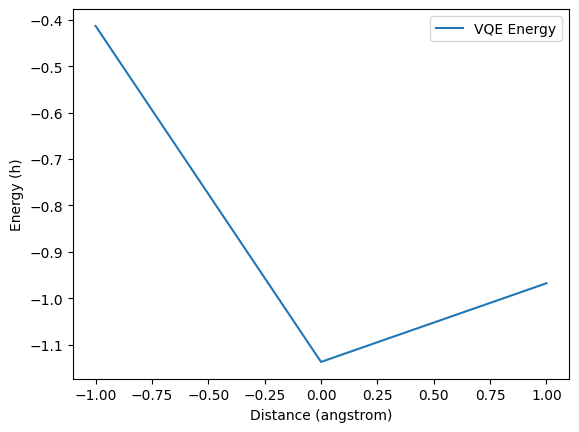

In [19]:
H2_fermionic_hamiltonian, H2_num_particles, H2_num_spin_orbitals, H2_qubit_op, H2_cubit_convertor, H2_ground_state = \
solve_ground_state(H2_info_dict, mapper_name='JordanWignerMapper', two_qubit_reduction=True, z2symmetry_reduction=None,
                   name_solver="NumPy exact solver", solver = numpy_solver, plot_bopes=True, show=True)

### LiH calculation

In [8]:
LiH_atoms = ["Li", "H"]
LiH_coords = [(0.0, 0.0, 0.0), (0.0, 0.0, 1.5474)]
LiH_charge = 0
LiH_multiplicity = 1
LiH_atom_pair = (1,0)
LiH_info_dict = {'atoms': LiH_atoms, 'coords': LiH_coords, 'charge': LiH_charge, 'multiplicity': LiH_multiplicity, 'atom_pair': LiH_atom_pair}

Fermionic Operator
number spin orbitals=12, number terms=1860
  0.8291920934789214 * ( +_0 +_0 -_0 -_0 )
+ -0.057138124485444544 * ( +_0 +_0 -_1 -_0 )
+ -0.06905217304573572 * ( +_0 +_0 -_2 -_0 )
+ 0.024193362225397114 * ( +_0 +_0 -_5 -_0 )
+ -0.057138124485444544 * ( +_0 +_1 -_0 -_0 )
+ 0.1866291618323826 * ( +_0 +_1 -_1 -_0 )
+ 0.0061835415381839365 * ( +_0 +_1 -_2 -_0 )
+ -0.017527752159757527 * ( +_0 +_1 -_5 -_0 )
+ -0.06905217304573572 * ( +_0 +_2 -_0 -_0 )
+ 0.0061835415381839365 * ( +_0 +_2 -_1 -_0 )
+ 0.19791338458570054 * ( +_0 +_2 -_2 -_0 )
+ 0.008745961619812927 * ( +_0 +_2 -_5 -_0 )
+ 0.19815704097777193 * ( +_0 +_3 -_3 -_0 )
+ 0.19815704097777206 * ( +_0 +_4 -_4 -_0 )
+ 0.024193362225397114 * ( +_0 +_5 -_0 -_0 )
+ -0.017527752159757527 * ( +_0 +_5 -_1 -_0 )
+ 0.008745961619812927 * ( +_0 +_5 -_2 -_0 )
+ 0.18088693340116224 * ( +_0 +_5 -_5 -_0 )
+ 0.8291920934789214 * ( +_0 +_6 -_6 -_0 )
+ -0.057138124485444544 * ( +_0 +_6 -_7 -_0 )
...
Number of particles:  (2, 2)
Number o

/tmp/ipython-input-3733693297.py:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  energy[k] = ground_state.total_energies


Number of items in Pauli list: 631
SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIZI', 'IIIIIIIIIIZZ', 'IIIIIIIIIYYI', 'IIIIIIIIIYYZ', 'IIIIIIIIIXXI', 'IIIIIIIIIXXZ', 'IIIIIIYZZZYI', 'IIIIIIYZZZYZ', 'IIIIIIXZZZXI', 'IIIIIIXZZZXZ', 'IIIIIIIIIZII', 'IIIIIIIIIZIZ', 'IIIIIIYZZYII', 'IIIIIIYZZYIZ', 'IIIIIIXZZXII', 'IIIIIIXZZXIZ', 'IIIIIIIIZIII', 'IIIIIIIIZIIZ'],
              coeffs=[-5.14497671e+00+0.j,  1.00871170e+00+0.j, -1.16698128e-01+0.j,
  8.98133335e-02+0.j, -7.63148506e-03+0.j, -2.47086631e-04+0.j,
 -7.63148506e-03+0.j, -2.47086631e-04+0.j,  5.93107508e-03+0.j,
  6.62412872e-03+0.j,  5.93107508e-03+0.j,  6.62412872e-03+0.j,
 -1.97736935e-01+0.j,  9.35595574e-02+0.j,  1.46025364e-02+0.j,
 -4.82846983e-03+0.j,  1.46025364e-02+0.j, -4.82846983e-03+0.j,
 -2.29622018e-01+0.j,  9.66238891e-02+0.j])
Running VQE using the NumPy exact solver
Elapsed time: 0:00:02.390242
Total ground state energy: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.908697

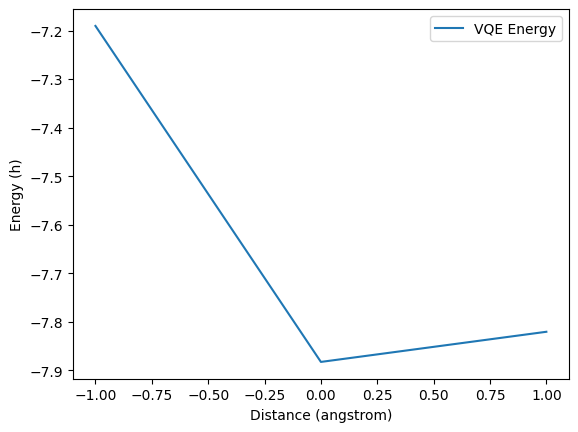

In [9]:
LiH_fermionic_hamiltonian, LiH_num_particles, LiH_num_spin_orbitals, LiH_qubit_op, LiH_cubit_convertor, LiH_ground_state = \
solve_ground_state(LiH_info_dict, mapper_name = 'JordanWignerMapper',  two_qubit_reduction=True, z2symmetry_reduction=None,
                   name_solver="NumPy exact solver", solver = numpy_solver, plot_bopes=True, show=True)